# Repeat quasars

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [7]:
from astropy.table import Table, join, hstack, unique
from astropy.io import ascii

 ### Query the data via `bossquery` from the bossdata package:
 #### http://bossdata.readthedocs.org/en/latest/scripts.html#bossquery

#### DR13 (BOSS+SEQUELS)

##### export BOSS_REDUX_VERSION=v5_9_0

`bossquery --full --what 'PLATE,MJD,FIBER,THING_ID,RUN,RERUN,CAMCOL,FIELD,ID,PLUG_RA,PLUG_DEC,SPECTROFLUX_1,SPECTROFLUX_2,SPECTROFLUX_3' --where 'CLASS="QSO" and ZWARNING=0 and Z_ERR>0 and RUN>0' --max-rows 500000 --save dr13_qsos.dat`

#### eBOSS 

##### export BOSS_REDUX_VERSION=v5_9_1

``bossquery --full --what 'PLATE,MJD,FIBER,THING_ID,RUN,RERUN,CAMCOL,FIELD,ID,PLUG_RA,PLUG_DEC,SPECTROFLUX_1,SPECTROFLUX_2,SPECTROFLUX_3' --where 'CLASS="QSO" and ZWARNING=0 and Z_ERR>0 and RUN>0 and EBOSS_TARGET1&4096>0' --max-rows 100000 --save eboss_qsos.dat``

In [31]:
boss = Table.read('dr13_qsos.dat', format='ascii')
eboss = Table.read('eboss_qsos.dat', format='ascii')

In [32]:
print 'boss returned {} quasars'.format(len(boss))
print 'eBOSS returned {} quasars'.format(len(eboss))

boss returned 373115 quasars
eBOSS returned 9851 quasars


### Match quasars

#### eBOSS/BOSS

In [5]:
eboss_boss_overlap = join(eboss, boss, keys=('RUN','RERUN','CAMCOL','FIELD', 'ID'), join_type='inner', table_names=('E','B'))
eboss_boss_overlap = eboss_boss_overlap.group_by(('PLATE_E','MJD_E','FIBER_E'))
eboss_boss_repeats = Table([eboss_boss_overlap['PLATE_E'], eboss_boss_overlap['MJD_E'], eboss_boss_overlap['FIBER_E'], eboss_boss_overlap['THING_ID_E'], eboss_boss_overlap['PLATE_B'], eboss_boss_overlap['MJD_B'], eboss_boss_overlap['FIBER_B'], eboss_boss_overlap['THING_ID_B']])

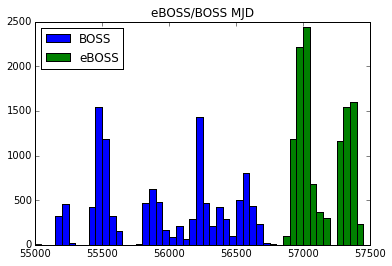

In [12]:
plt.title('eBOSS/BOSS MJD')
plt.hist(eboss_boss_repeats['MJD_B'], bins=50, color='b', label='BOSS', range=(55000, 57500))
plt.hist(eboss_boss_repeats['MJD_E'], bins=50, color='g', label='eBOSS', range=(55000, 57500))
plt.legend(loc='upper left');

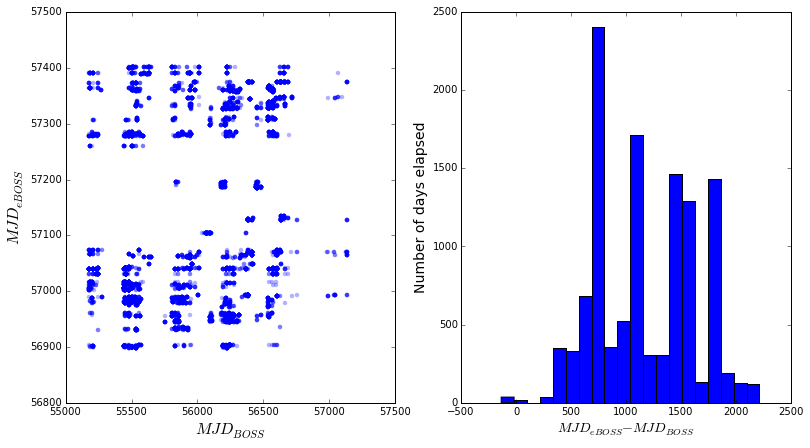

In [17]:
fig = plt.figure(figsize=(13,7))
plt.subplot(1,2,1)
plt.scatter(eboss_boss_repeats['MJD_B'], eboss_boss_repeats['MJD_E'], color='b',lw=0, alpha=0.3)
plt.xlabel('$MJD_{BOSS}$', fontsize=16)
plt.ylabel('$MJD_{eBOSS}$', fontsize=16)
plt.subplot(1,2,2)
plt.hist(eboss_boss_repeats['MJD_E']-eboss_boss_repeats['MJD_B'], color='b', bins=20)
plt.xlabel('$MJD_{eBOSS}-MJD_{BOSS}$', fontsize=14)
plt.ylabel('Number of days elapsed', fontsize=14);

In [24]:
def plot_statistics(x, y, num_bins):
    good_vals = np.isfinite(y)
    y = y[good_vals]
    x = x[good_vals]
    in_window = (y > np.percentile(y, 1))&(y < np.percentile(y, 99))
    y = y[in_window]
    x = x[in_window]
    y_mean = np.mean(y)
    percentile_step = 100./num_bins
    bin_edges = (0.5 + np.arange(1, 6)) * 365.25
    zero_order = np.histogram(x, bins=bin_edges)[0]
    first_order = np.histogram(x, bins=bin_edges, weights=y)[0]
    second_order = np.histogram(x, bins=bin_edges, weights=y**2)[0]
    mean = first_order/zero_order
    std_dev = np.sqrt(second_order/zero_order - mean**2)
    mean_err = std_dev/np.sqrt(zero_order)
    std_dev_err = std_dev/np.sqrt(2*(zero_order-1))
    x_axis = (bin_edges[:-1]+bin_edges[1:])/2.
    plt.figure(figsize=(13,6))
    plt.subplot(1,2,1)
    plt.scatter(x, y, lw=0, color='r', alpha=0.1)
    plt.ylim(-.1,.1)
    plt.xlim(600, 2000)
    plt.errorbar(x_axis, mean, ls='None', color='b', lw=1.5, yerr=mean_err)
    plt.xlabel('$\Delta MJD$', fontsize=16)
    plt.ylabel('$Mean\,(m_{eB} - m_{B})$', fontsize=16)
    plt.grid()
    plt.subplot(1,2,2)
    plt.scatter(x_axis, std_dev, lw=0, color='r', alpha=0.5)
    plt.errorbar(x_axis, std_dev, ls='None', color='g', lw=1.5, yerr=std_dev_err)
    plt.xlabel('$\Delta MJD$', fontsize=16)
    plt.ylabel('$Std\,Dev\,(m_{eB} - m_{B})$', fontsize=16)
    plt.grid()

##### g-band 

/Users/belaabolfathi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


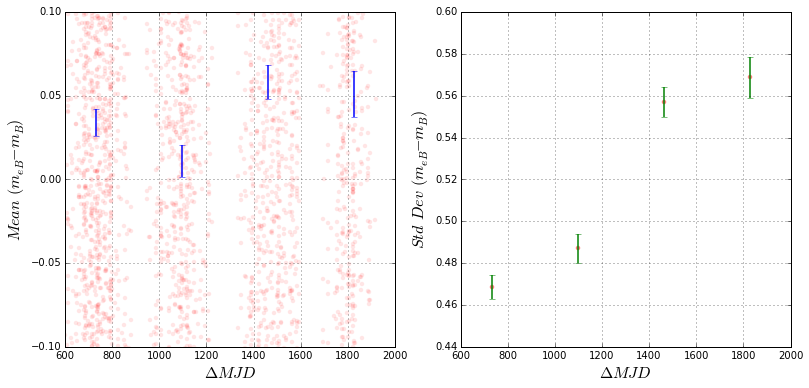

In [25]:
plot_statistics(eboss_boss_overlap['MJD_E']-eboss_boss_overlap['MJD_B'], 
                -2.5*np.log10(eboss_boss_overlap['SPECTROFLUX_1_E']/eboss_boss_overlap['SPECTROFLUX_1_B']), 10)

##### r-band

/Users/belaabolfathi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


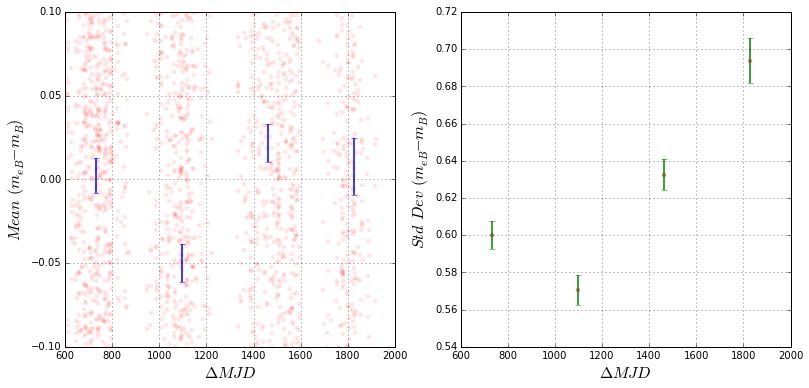

In [29]:
plot_statistics(eboss_boss_overlap['MJD_E']-eboss_boss_overlap['MJD_B'], 
                -2.5*np.log10(eboss_boss_overlap['SPECTROFLUX_2_E']/eboss_boss_overlap['SPECTROFLUX_2_B']), 10)

##### i-band

/Users/belaabolfathi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


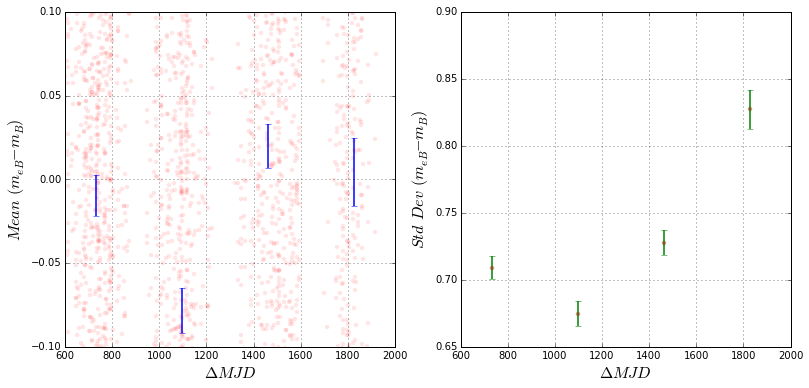

In [28]:
plot_statistics(eboss_boss_overlap['MJD_E']-eboss_boss_overlap['MJD_B'], 
                -2.5*np.log10(eboss_boss_overlap['SPECTROFLUX_3_E']/eboss_boss_overlap['SPECTROFLUX_3_B']), 10)